In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data from drive

In [3]:
test_path ="/content/drive/MyDrive/HerWill Datathon/test.csv"
train_path = "/content/drive/MyDrive/HerWill Datathon/train.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Preprocess the data

In [ ]:
null_train =  train.isnull().any()
null_train

,0
id,False
passage,False
y,False


In [ ]:
null_test =  test.isnull().any()
null_test

,0
id,False
passage,False


In [ ]:
train.head()

,id,passage,y
0,0,Women are always the ones struggling in math c...,1
1,1,Men in education often just boss around and ne...,0
2,2,Non-binary students are just confused about th...,2
3,3,Science classrooms are designed to be neutral ...,3
4,4,Male teachers often believe they are superior ...,0


In [4]:
# creat validation data

X_train, X_val, y_train, y_val = train_test_split(train['passage'] , train['y'], test_size=0.2, random_state=42)

# Custom Dataset class creation

In [5]:
# Convert the encoded data into PyTorch datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are LongTensor
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Define metrics

In [6]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


# Calculate NOP

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [8]:
pip install thop

In [9]:

from thop import profile

def measure_nop(model, inputs):
    # Forward pass through the model to get NOP
    flops, params = profile(model, inputs=(inputs['input_ids'], inputs['attention_mask']))
    return flops, params


# Model 1: roberta-base

In [10]:

from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)

## Tokenization: roberta-base

In [11]:
# Load the tokenizer and encode the data
tokenizer1 = RobertaTokenizerFast.from_pretrained('roberta-base')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
token_lengths = [len(tokenizer1.encode(text, add_special_tokens=True)) for text in X_train]
# Set the max_length to cover 90-95% of token lengths
best_max_length = int(np.percentile(token_lengths, 95))
print("Optimal max_length:", best_max_length)

Optimal max_length: 39


In [13]:
train_encode1 = tokenizer1(list(X_train), truncation=True, padding=True, max_length=best_max_length)
val_encode1 = tokenizer1(list(X_val), truncation=True, padding=True, max_length=best_max_length)
test_encode1 = tokenizer1(list(test["passage"]), truncation=True, padding=True, max_length=best_max_length)

In [14]:
# Creating dataset objects for train and val datasets

tarin_data1 = SentimentDataset(train_encode1, y_train.to_numpy())
val_data1   = SentimentDataset(val_encode1,   y_val.to_numpy())



## Load the model and Train

In [15]:
# Load the model for sequence classification
model1 = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = 4)



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Define training arguments
training_args1 = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    learning_rate=2e-5,  # I change the lr alot and decied to go with 2e-5

)

# Create Trainer instance
trainer1 = Trainer(
    model=model1,
    args=training_args1,
    train_dataset=tarin_data1,
    eval_dataset=val_data1,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Train the model
trainer1.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.165200,0.131896,0.966429,0.965964,0.966990,0.966429
2,0.089600,0.117224,0.972143,0.972111,0.972089,0.972143
3,0.044700,0.151717,0.965000,0.965197,0.965608,0.965000
4,0.000800,0.160597,0.970714,0.970942,0.971614,0.970714


TrainOutput(global_step=2800, training_loss=0.21067232636069613, metrics={'train_runtime': 376.6732, 'train_samples_per_second': 59.468, 'train_steps_per_second': 7.434, 'total_flos': 448941299788800.0, 'train_loss': 0.21067232636069613, 'epoch': 4.0})

## Test & evaluate

In [18]:
# Evaluate the model
eval_result1 = trainer1.evaluate()
print("Evaluation Results:", eval_result1)

Evaluation Results: {'eval_loss': 0.16059662401676178, 'eval_accuracy': 0.9707142857142858, 'eval_f1': 0.9709422855623562, 'eval_precision': 0.9716135596974735, 'eval_recall': 0.9707142857142858, 'eval_runtime': 3.6004, 'eval_samples_per_second': 388.848, 'eval_steps_per_second': 48.606, 'epoch': 4.0}


In [19]:

# Make predictions on the test set
test_dataset1 = SentimentDataset(test_encode1)
predictions1 = trainer1.predict(test_dataset1)

# Convert logits to probabilities and then to predicted labels
preds1 = np.argmax(predictions1.predictions, axis=1)

In [20]:


NOP1 = 0

for idx, row in test.iterrows():
    inputs = tokenizer1(row["passage"], return_tensors="pt", padding=True, truncation=True).to(device)
    flops, NOP1 = measure_nop(model1, inputs)
    break

print(NOP1)


[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
85649668.0


## Create the submission DataFrame

In [21]:

submission_df1 = pd.DataFrame({
    'id': test['id'],
    'y_pred': preds1,
    'parameters': NOP1
})



In [23]:
submission_df1

,id,y_pred,parameters
0,7000,0,85649668.0
1,7001,1,85649668.0
2,7002,2,85649668.0
3,7003,0,85649668.0
4,7004,1,85649668.0
...,...,...,...
2995,9995,0,85649668.0
2996,9996,2,85649668.0
2997,9997,3,85649668.0
2998,9998,1,85649668.0


In [22]:

# Save the predictions to a CSV file
submission_df1.to_csv('sample_solution_roberta-base.csv', index=False)

# Model 2: bert-base-uncased

In [24]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


## Tokenization

In [25]:
tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [26]:
train_encode2 = tokenizer2(list(X_train), truncation=True, padding=True, max_length=128)
val_encode2 = tokenizer2(list(X_val), truncation=True, padding=True, max_length=128)
test_encode2 = tokenizer2(list(test["passage"]), truncation=True, padding=True, max_length=128)

In [27]:


tarin_data2 = SentimentDataset(train_encode2, y_train.to_numpy())
val_data2   = SentimentDataset(val_encode2,   y_val.to_numpy())


## Load the model and Train

In [28]:
model2 = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Define training arguments
training_args2 = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    learning_rate=2e-5,

)

# Create Trainer instance
trainer2 = Trainer(
    model=model2,
    args=training_args2,
    train_dataset=tarin_data2,
    eval_dataset=val_data2,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
# Train the model
trainer2.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.136200,0.142940,0.961429,0.960858,0.961703,0.961429
2,0.061500,0.168073,0.962857,0.962744,0.962743,0.962857
3,0.008700,0.173903,0.963571,0.963593,0.963699,0.963571
4,0.013000,0.175192,0.963571,0.963601,0.963676,0.963571


TrainOutput(global_step=2800, training_loss=0.20452795246416436, metrics={'train_runtime': 469.4447, 'train_samples_per_second': 47.716, 'train_steps_per_second': 5.964, 'total_flos': 886371284198400.0, 'train_loss': 0.20452795246416436, 'epoch': 4.0})

## Test & evaluate

In [62]:
# Evaluate the model
eval_result2 = trainer2.evaluate()
print("Evaluation Results:", eval_result2)

Evaluation Results: {'eval_loss': 0.17519186437129974, 'eval_accuracy': 0.9635714285714285, 'eval_f1': 0.9636008112584432, 'eval_precision': 0.9636764878410615, 'eval_recall': 0.9635714285714285, 'eval_runtime': 9.2108, 'eval_samples_per_second': 151.996, 'eval_steps_per_second': 19.0, 'epoch': 4.0}


In [31]:
# Make predictions on the test set
test_dataset2 = SentimentDataset(test_encode2)
predictions2 = trainer2.predict(test_dataset2)

# Convert logits to probabilities and then to predicted labels
preds2 = np.argmax(predictions2.predictions, axis=1)

In [32]:

NOP2 = 0

for idx, row in test.iterrows():
    inputs = tokenizer2(row["passage"], return_tensors="pt", padding=True, truncation=True).to(device)
    flops, NOP2 = measure_nop(model2, inputs)
    break

print(NOP2)

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
85649668.0


## Create the submission DataFrame

In [33]:
# Create the submission DataFrame
submission_df2 = pd.DataFrame({
    'id': test['id'],
    'y_pred': preds2,
    'parameters': NOP2
})


# Save the predictions to a CSV file
submission_df2.to_csv('sample_solution_bert-base-uncased.csv', index=False)

# Model 3: XLNet

In [34]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments


## Tokenization

In [35]:
# Load XLNet tokenizer
tokenizer3 = XLNetTokenizer.from_pretrained('xlnet-base-cased')


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
# Tokenize data
train_encodings3 = tokenizer3(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings3 = tokenizer3(list(X_val), truncation=True, padding=True, max_length=128)


In [37]:

train_dataset3 = SentimentDataset(train_encodings3, y_train.to_numpy())
val_dataset3 = SentimentDataset(val_encodings3, y_val.to_numpy())

## Load the model and Train

In [38]:
model3 = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=4)


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
training_args3 = TrainingArguments(
    output_dir='None',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=2e-5
)

trainer3 = Trainer(
    model=model3,
    args=training_args3,
    train_dataset=train_dataset3,
    eval_dataset=val_dataset3,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
for param in model3.parameters():
    param.data = param.data.contiguous()

In [41]:
trainer3.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.325700,0.133243,0.967143,0.966695,0.967552,0.967143
2,0.192100,0.151157,0.968571,0.968506,0.968480,0.968571
3,0.108900,0.173761,0.967143,0.967481,0.968385,0.967143
4,0.080200,0.185906,0.967857,0.968173,0.969038,0.967857


TrainOutput(global_step=2800, training_loss=0.159156311580113, metrics={'train_runtime': 723.6273, 'train_samples_per_second': 30.955, 'train_steps_per_second': 3.869, 'total_flos': 947242639257600.0, 'train_loss': 0.159156311580113, 'epoch': 4.0})

## Test & evaluate

In [42]:
# Evaluate the model
eval_result3 = trainer3.evaluate()
print("Evaluation Results:", eval_result3)

Evaluation Results: {'eval_loss': 0.18590621650218964, 'eval_accuracy': 0.9678571428571429, 'eval_f1': 0.9681725335409271, 'eval_precision': 0.9690376343037543, 'eval_recall': 0.9678571428571429, 'eval_runtime': 13.2713, 'eval_samples_per_second': 105.491, 'eval_steps_per_second': 13.186, 'epoch': 4.0}


In [43]:
# Make predictions on the test set
test_encode3 = tokenizer3(list(test["passage"]), truncation=True, padding=True, max_length=128)

test_dataset3 = SentimentDataset(test_encode3)
predictions3 = trainer3.predict(test_dataset3)



In [44]:


# Convert logits to probabilities and then to predicted labels
preds3 = np.argmax(predictions3.predictions, axis=1)

NOP3 = 0

for idx, row in test.iterrows():
    inputs = tokenizer3(row["passage"], return_tensors="pt", padding=True, truncation=True).to(device)
    flops, NOP3 = measure_nop(model3, inputs)
    break

print(NOP3)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
57299716.0


## Create the submission DataFrame

In [45]:

submission_df3 = pd.DataFrame({
    'id': test['id'],
    'y_pred': preds3,
    'parameters': NOP3
})


# Save the predictions to a CSV file
submission_df3.to_csv('sample_solution_XLNET.csv', index=False)

# Model 4: bert-tiny

In [47]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Load BERT-tiny model and tokenizer
model_name = "prajjwal1/bert-tiny"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## tokenization

In [48]:
train_encode2 = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encode2 = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
test_encode2 = tokenizer(list(test["passage"]), truncation=True, padding=True, max_length=128)

tarin_data2 = SentimentDataset(train_encode2, y_train.to_numpy())
val_data2   = SentimentDataset(val_encode2,   y_val.to_numpy())


## Train the model

In [52]:
training_args = TrainingArguments(
    output_dir="None",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [65]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tarin_data2,
    eval_dataset=val_data2,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [56]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()


In [66]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.236000,0.217700,0.941429,0.940028,0.942206,0.941429
2,0.249000,0.208107,0.947143,0.945880,0.948260,0.947143
3,0.239800,0.202820,0.947857,0.946702,0.948726,0.947857
4,0.225200,0.204189,0.949286,0.948133,0.950466,0.949286


TrainOutput(global_step=2800, training_loss=0.2366089357648577, metrics={'train_runtime': 53.551, 'train_samples_per_second': 418.293, 'train_steps_per_second': 52.287, 'total_flos': 4282623206400.0, 'train_loss': 0.2366089357648577, 'epoch': 4.0})

## Test & evaluate

In [67]:
# Evaluate the model
eval_result = trainer.evaluate()
print("Evaluation Results:", eval_result)

Evaluation Results: {'eval_loss': 0.2041894793510437, 'eval_accuracy': 0.9492857142857143, 'eval_f1': 0.9481329292441959, 'eval_precision': 0.9504655804389638, 'eval_recall': 0.9492857142857143, 'eval_runtime': 0.8896, 'eval_samples_per_second': 1573.804, 'eval_steps_per_second': 196.726, 'epoch': 4.0}


In [58]:
# Make predictions on the test set
test_encode = tokenizer(list(test["passage"]), truncation=True, padding=True, max_length=128)

test_dataset = SentimentDataset(test_encode)
predictions = trainer.predict(test_dataset)

In [59]:
# Convert logits to probabilities and then to predicted labels
preds = np.argmax(predictions.predictions, axis=1)

NOP = 0

for idx, row in test.iterrows():
    inputs = tokenizer(row["passage"], return_tensors="pt", padding=True, truncation=True).to(device)
    flops, NOP = measure_nop(model, inputs)
    break

print(NOP)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
413828.0


## Create the submission DataFrame

In [60]:

submission_df = pd.DataFrame({
    'id': test['id'],
    'y_pred': preds,
    'parameters': NOP
})


# Save the predictions to a CSV file
submission_df.to_csv('bert-tiny.csv', index=False)

# Model 5: Albert

In [70]:

from transformers import AlbertForSequenceClassification, AlbertTokenizer

# Load the ALBERT model and tokenizer for fine-tuning
model5 = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=4)
tokenizer5 = AlbertTokenizer.from_pretrained("albert-base-v2")


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Tokenization

In [71]:
# Tokenize data
train_encodings5 = tokenizer5(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings5 = tokenizer5(list(X_val), truncation=True, padding=True, max_length=128)

In [72]:

train_dataset5 = SentimentDataset(train_encodings5, y_train.to_numpy())
val_dataset5 = SentimentDataset(val_encodings5, y_val.to_numpy())

## Train the model

In [73]:
training_args5 = TrainingArguments(
    output_dir='None',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    learning_rate=2e-5
)

trainer5 = Trainer(
    model=model5,
    args=training_args5,
    train_dataset=train_dataset5,
    eval_dataset=val_dataset5,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [74]:
trainer5.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.384000,0.252986,0.947857,0.947000,0.950585,0.947857
2,0.245100,0.171844,0.963571,0.963307,0.963875,0.963571
3,0.133000,0.183828,0.957857,0.958177,0.958762,0.957857
4,0.096600,0.177816,0.964286,0.964313,0.964365,0.964286


TrainOutput(global_step=2800, training_loss=0.19284698622567312, metrics={'train_runtime': 383.2966, 'train_samples_per_second': 58.44, 'train_steps_per_second': 7.305, 'total_flos': 79476898099200.0, 'train_loss': 0.19284698622567312, 'epoch': 4.0})

## Test & evaluate

In [75]:
# Evaluate the model
eval_result5 = trainer5.evaluate()
print("Evaluation Results:", eval_result5)

Evaluation Results: {'eval_loss': 0.17781586945056915, 'eval_accuracy': 0.9642857142857143, 'eval_f1': 0.9643132557773489, 'eval_precision': 0.9643647853410485, 'eval_recall': 0.9642857142857143, 'eval_runtime': 12.1565, 'eval_samples_per_second': 115.165, 'eval_steps_per_second': 14.396, 'epoch': 4.0}


In [76]:
# Make predictions on the test set
test_encode5 = tokenizer5(list(test["passage"]), truncation=True, padding=True, max_length=128)

test_dataset5 = SentimentDataset(test_encode5)
predictions5 = trainer5.predict(test_dataset5)



In [77]:

# Convert logits to probabilities and then to predicted labels
preds5 = np.argmax(predictions5.predictions, axis=1)

NOP5 = 0

for idx, row in test.iterrows():
    inputs = tokenizer5(row["passage"], return_tensors="pt", padding=True, truncation=True).to(device)
    flops, NOP5 = measure_nop(model5, inputs)
    break

print(NOP5)

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
7780868.0


## Create the submission DataFrame


In [78]:
submission_df5 = pd.DataFrame({
    'id': test['id'],
    'y_pred': preds5,
    'parameters': NOP5
})


# Save the predictions to a CSV file
submission_df5.to_csv('sample_solution_Albert.csv', index=False)

# Analysis and Best Model

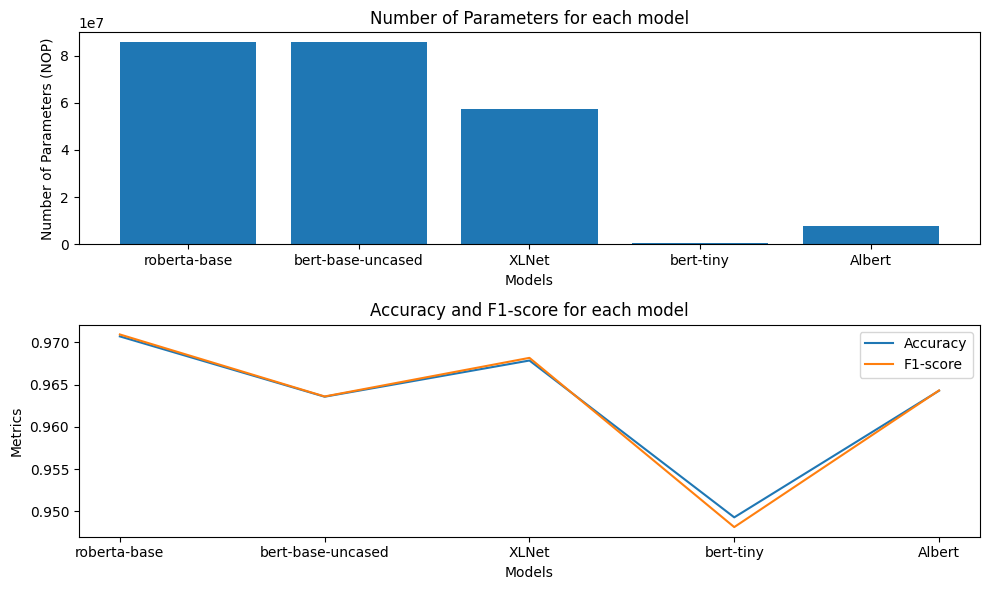

In [79]:

import matplotlib.pyplot as plt



model_names = ['roberta-base', 'bert-base-uncased', 'XLNet', 'bert-tiny', 'Albert']
nop_values = [NOP1, NOP2, NOP3, NOP, NOP5]
accuracy_values = [eval_result1['eval_accuracy'], eval_result2['eval_accuracy'], eval_result3['eval_accuracy'], eval_result['eval_accuracy'], eval_result5['eval_accuracy']]
f1_values = [eval_result1['eval_f1'], eval_result2['eval_f1'], eval_result3['eval_f1'], eval_result['eval_f1'], eval_result5['eval_f1']]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot NOP values
plt.subplot(2, 1, 1)
plt.bar(model_names, nop_values)
plt.xlabel("Models")
plt.ylabel("Number of Parameters (NOP)")
plt.title("Number of Parameters for each model")

# Plot Accuracy and F1 values
plt.subplot(2, 1, 2)
plt.plot(model_names, accuracy_values, label="Accuracy")
plt.plot(model_names, f1_values, label="F1-score")
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Accuracy and F1-score for each model")
plt.legend()

plt.tight_layout() # Adjusts subplot parameters for a tight layout.
plt.show()

**bert-tiny** has the smallest number of parameters, but it also has a significantly lower F1-score.
 **XLNet** has fewer parameters than roberta-base and bert-base-uncased but still maintains a high F1-score.
### **This makes XLNet and albert a good balance between model size and performance.**